In [1]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24


In [2]:
inputImageFile = ('test_segment.png')  # Easy1.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

In [3]:
imNmzd = imInput


In [6]:
stainColorMap = {
    'hematoxylin': [0.64, 0.72, 0.27],
    'eosin':       [0.09, 0.95, 0.28],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains


# create initial stain matrix
W_init = np.array([stainColorMap[stain_1],
                   stainColorMap[stain_2]]).T

# perform sparse color deconvolution
sparsity_factor = 0.1

imDeconvolved, W_est = htk.preprocessing.color_deconvolution.sparse_color_deconvolution(
    imInput, W_init, sparsity_factor)

print 'Estimated stain colors (in rows): '
print W_est.T


Estimated stain colors (in rows): 
[[ 0.49981424  0.74230077  0.44629059]
 [ 0.17054478  0.77252766  0.61164981]]


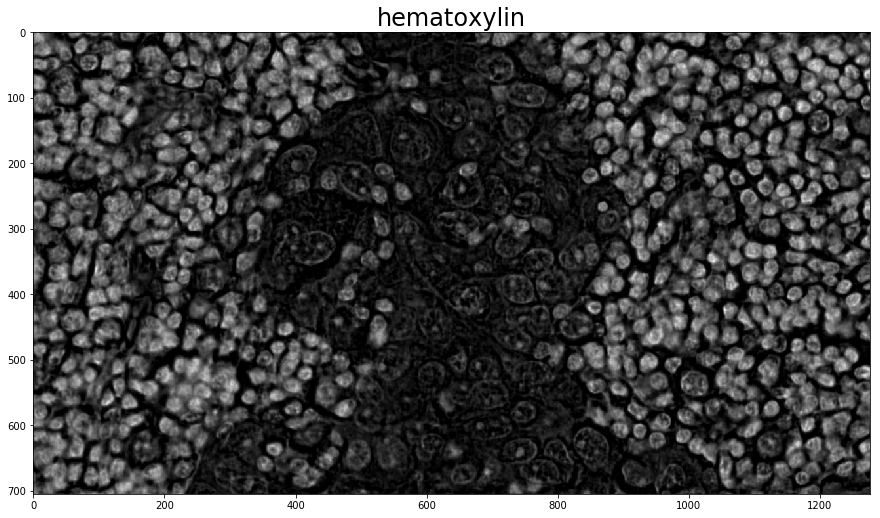

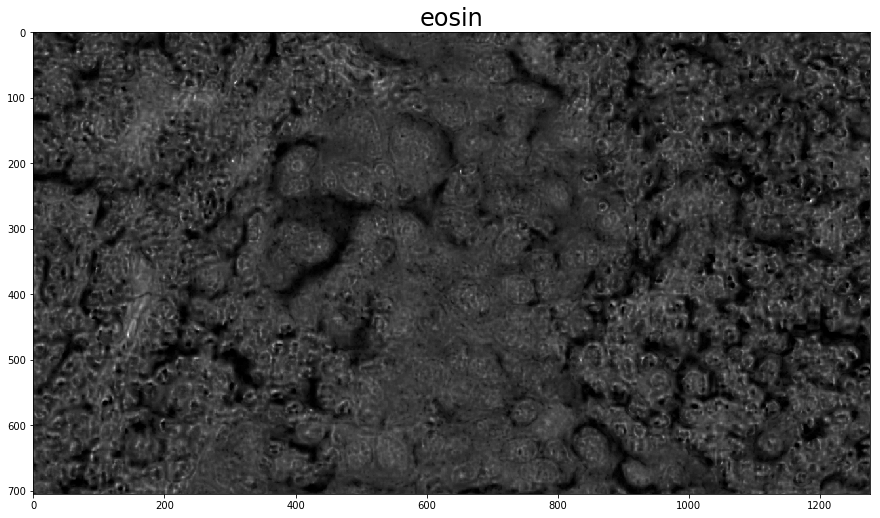

In [7]:
plt.figure()
plt.imshow(imDeconvolved[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.figure()
plt.imshow(imDeconvolved[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

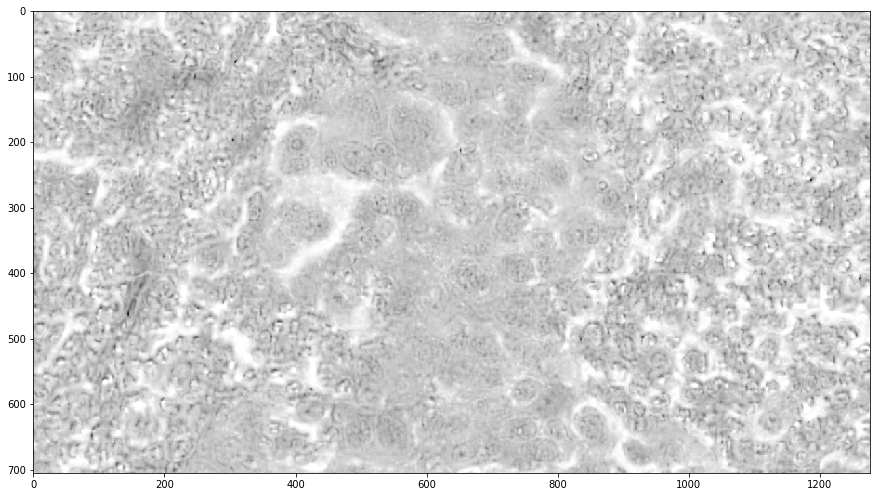

In [19]:
imNucleiStain1=imDeconvolved[:, :, 1]
imNucleiStain =255-imDeconvolved[:, :, 1]
plt.figure()
plt.imshow(imNucleiStain)
plt.show()

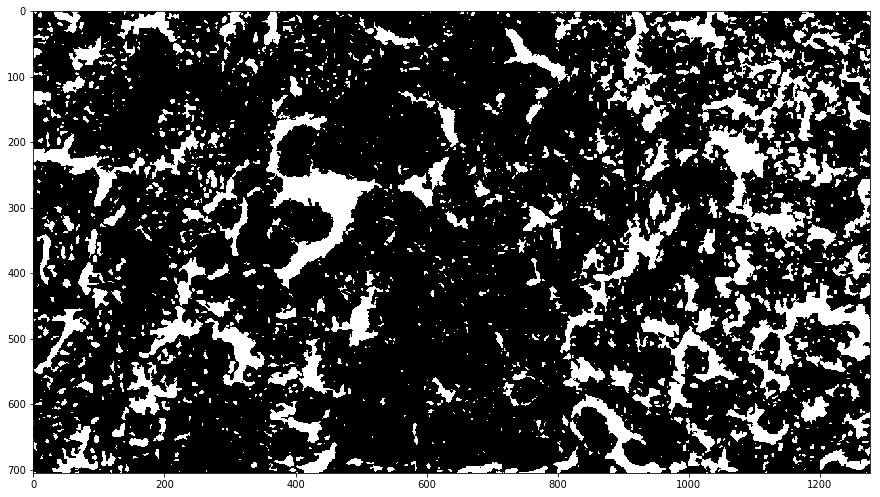

In [26]:
foreground_threshold =15

imFgndMask = sp.ndimage.morphology.binary_fill_holes(
    imNucleiStain1 < foreground_threshold)
plt.figure()
plt.imshow(imFgndMask)
plt.show()

In [40]:
# segment foreground
min_radius = 3
max_radius = 15

imLog = htk.filters.shape.clog(imNucleiStain, imFgndMask,
                               sigma_min=min_radius * np.sqrt(2),
                               sigma_max=max_radius * np.sqrt(2))


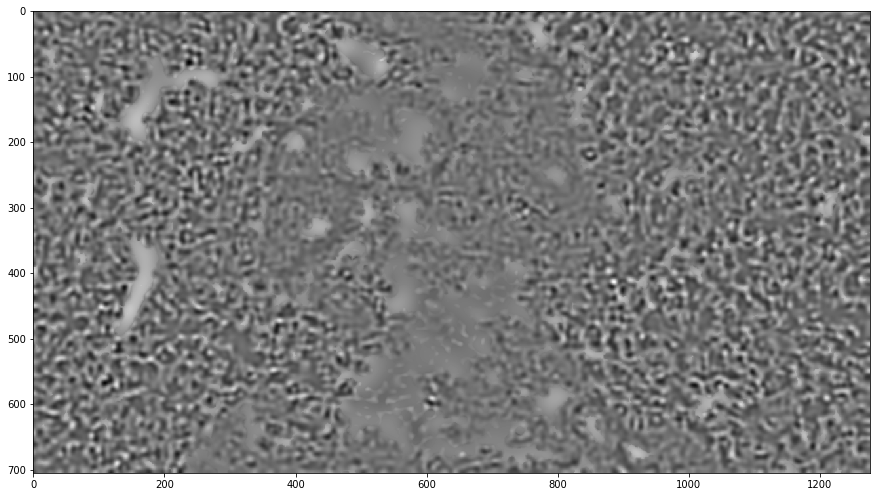

In [41]:
plt.figure()
plt.imshow(imLog[0])
plt.show()

Number of nuclei =  1030


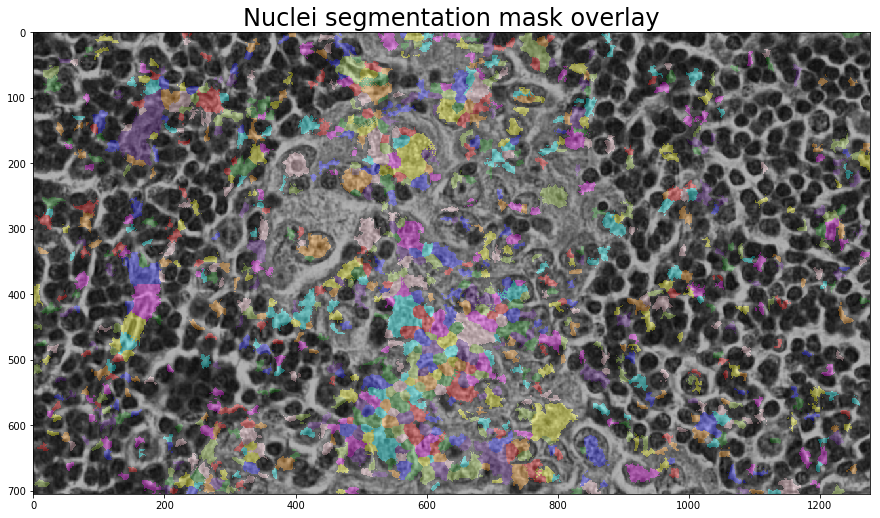

In [42]:
# detect and segment nuclei using local maximum clustering
local_max_search_radius = 5

imNucleiSegMask, Seeds, Max = htk.segmentation.nuclear.max_clustering(
    imLog[0], imFgndMask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

imNucleiSegMask = htk.segmentation.label.area_open(
    imNucleiSegMask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(imNucleiSegMask)

print 'Number of nuclei = ', len(objProps)

# Display results
plt.figure()

plt.imshow(skimage.color.label2rgb(imNucleiSegMask, imInput, bg_label=0))
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)



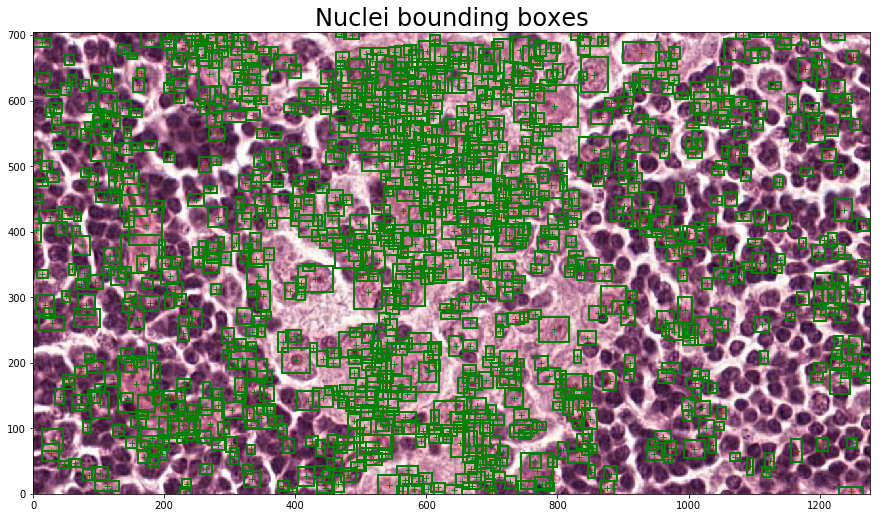

In [43]:
plt.figure()
plt.imshow( imInput )
plt.xlim([0, imInput.shape[1]])
plt.ylim([0, imInput.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)


In [ ]:
for i in range(600,700):
    for j in range(0,200):
        if imNucleiStain1[i][j]>5:
            print i,j,imNucleiStain[i][j]
        